In [114]:
import scanpy as sc
import numpy as np
import random
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
random.seed(66)

data_path = "E:/Opossum_M1/output/"
sample_ID = "NW_TX0092-8"

adata = sc.read_10x_h5(data_path + sample_ID + "/outs/filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
adata.obs["sample_id"] = [sample_ID] * adata.n_obs
adata

reading E:/Opossum_M1/output/NW_TX0092-8/outs/filtered_feature_bc_matrix.h5
 (0:00:01)


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 14226 × 21715
    obs: 'sample_id'
    var: 'gene_ids', 'feature_types', 'genome'

In [115]:
sc.pp.filter_cells(adata, min_genes=700)
sc.pp.filter_genes(adata, min_cells=8)

filtered out 446 cells that have less than 700 genes expressed
filtered out 4606 genes that are detected in less than 8 cells


In [116]:
adata.obs["n_UMIs"] = np.sum(adata.X, axis=1)

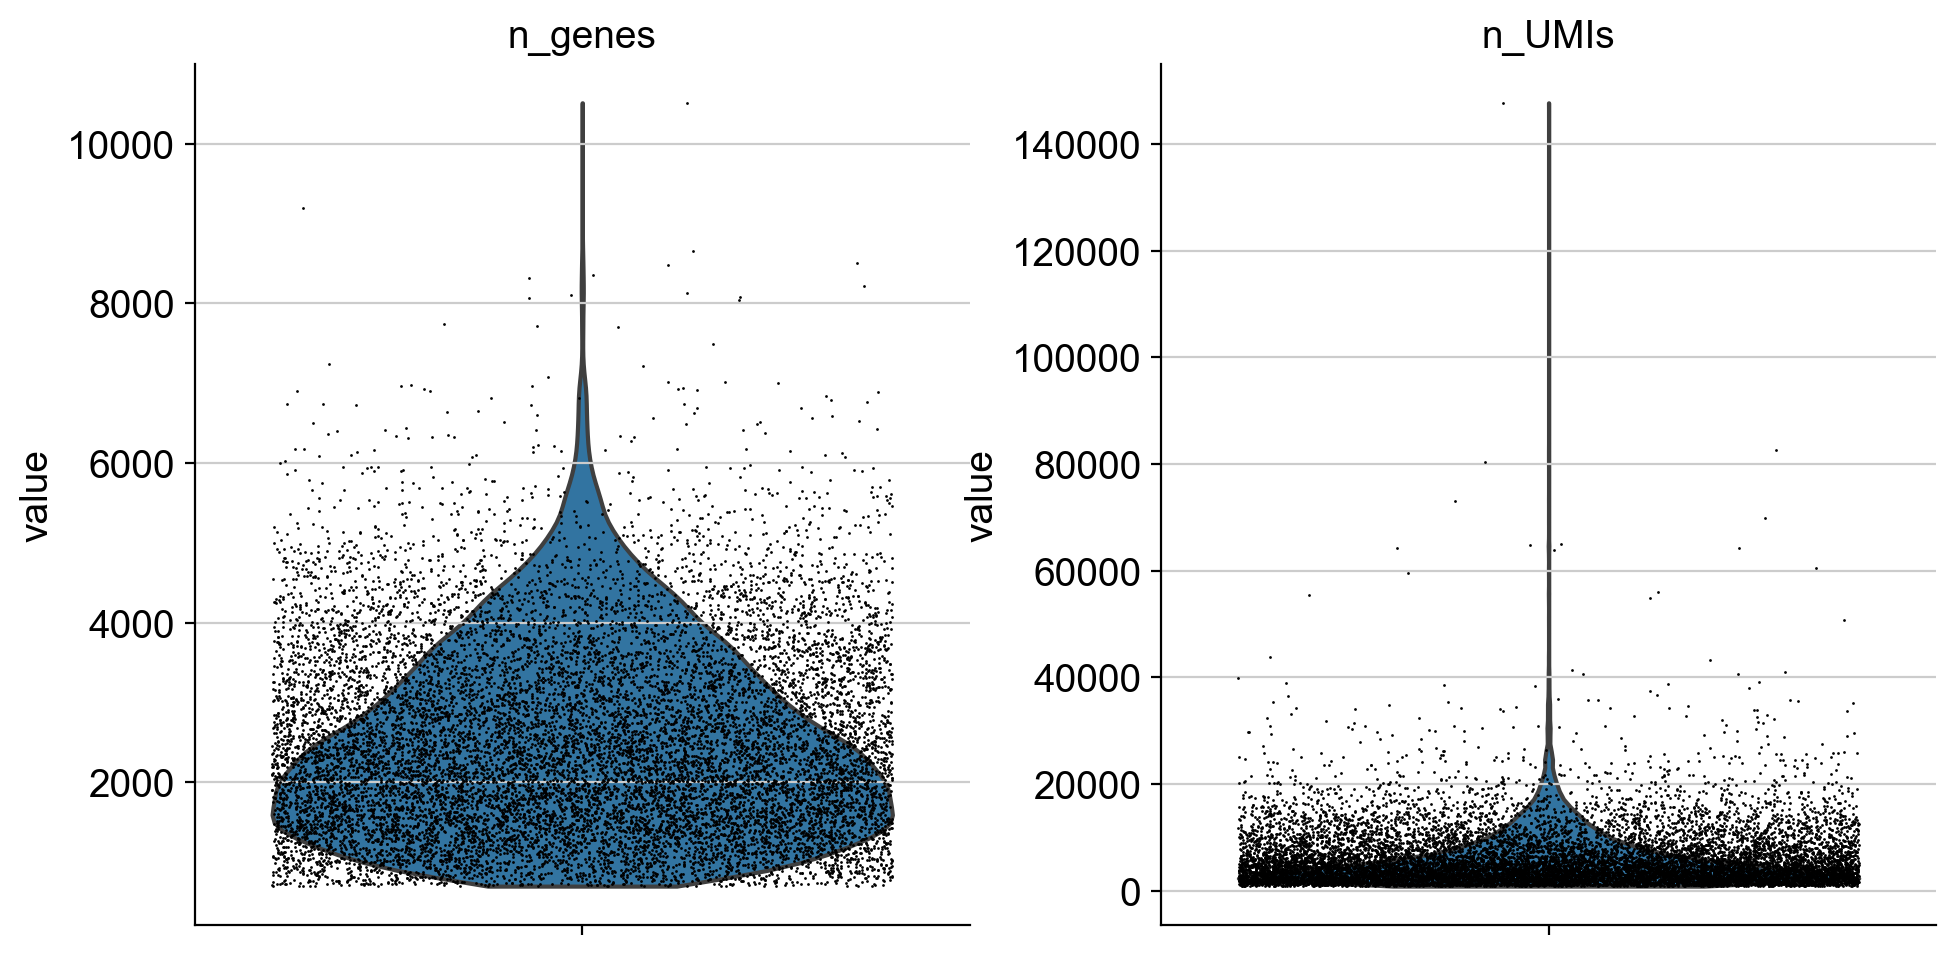

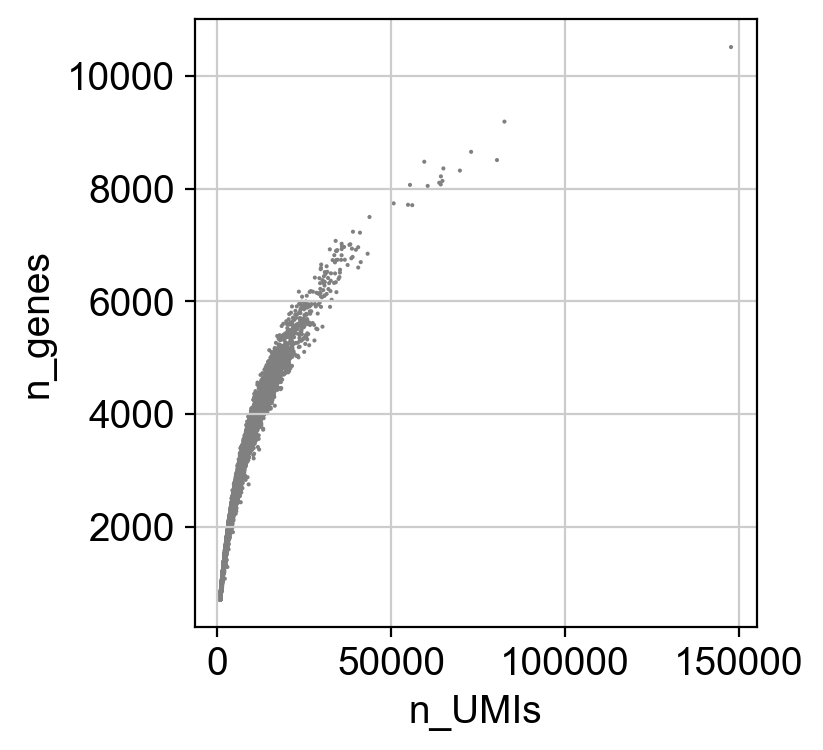

In [117]:
sc.pl.violin(adata, ["n_genes", "n_UMIs"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='n_UMIs', y='n_genes')

In [118]:
adata = adata[adata.obs["n_genes"] < 6500, :]
adata = adata[adata.obs["n_UMIs"] < 40000, :]

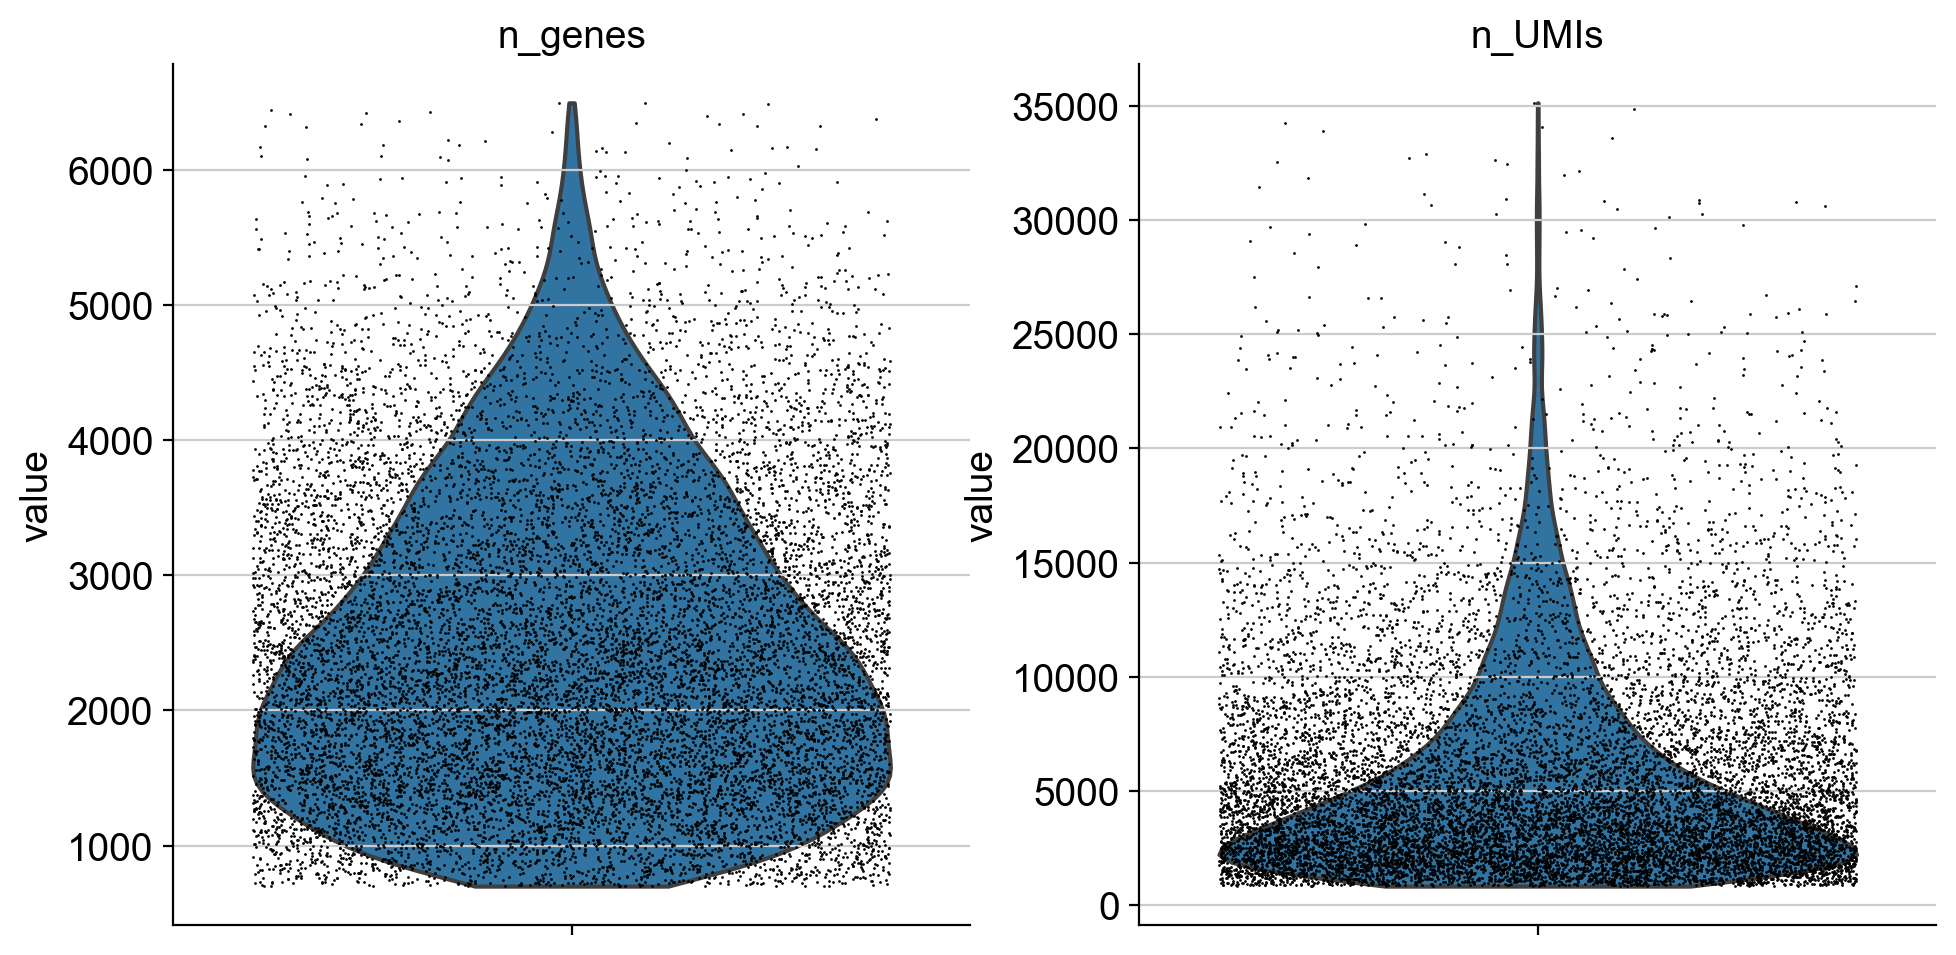

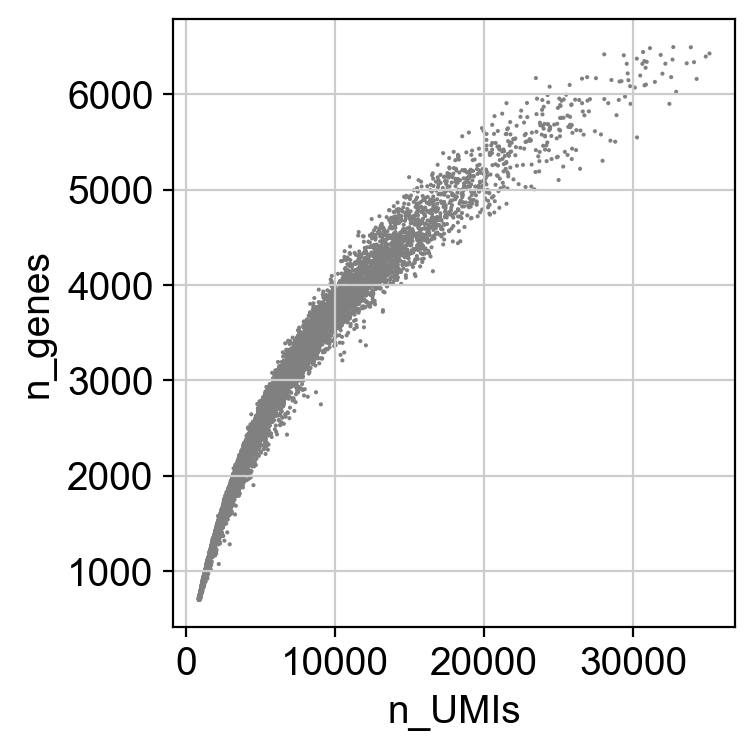

In [119]:
sc.pl.violin(adata, ["n_genes", "n_UMIs"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x="n_UMIs", y="n_genes")

In [120]:
import scrublet as scr

counts_matrix = adata.X
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.06)

doublet_scores, predicted_doublets = scrub.scrub_doublets(min_cells=8, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=40)

adata.obs["doublet"] = scrub.predicted_doublets_
adata.obs["doublet_score"] = scrub.doublet_scores_obs_

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.0%
Elapsed time: 19.9 seconds


C:\Users\TLab\AppData\Local\Temp\ipykernel_12516\1727709204.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet"] = scrub.predicted_doublets_


(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

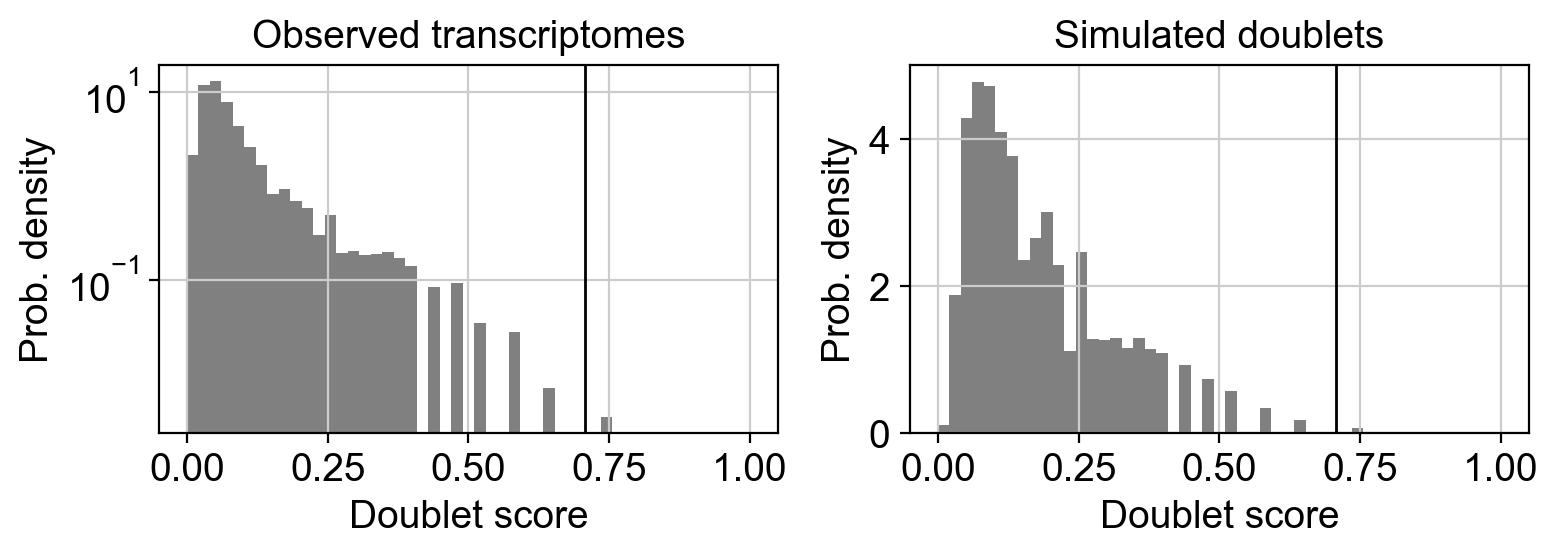

In [121]:
scrub.plot_histogram()

In [122]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.write_h5ad(data_path + sample_ID + ".h5ad")
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


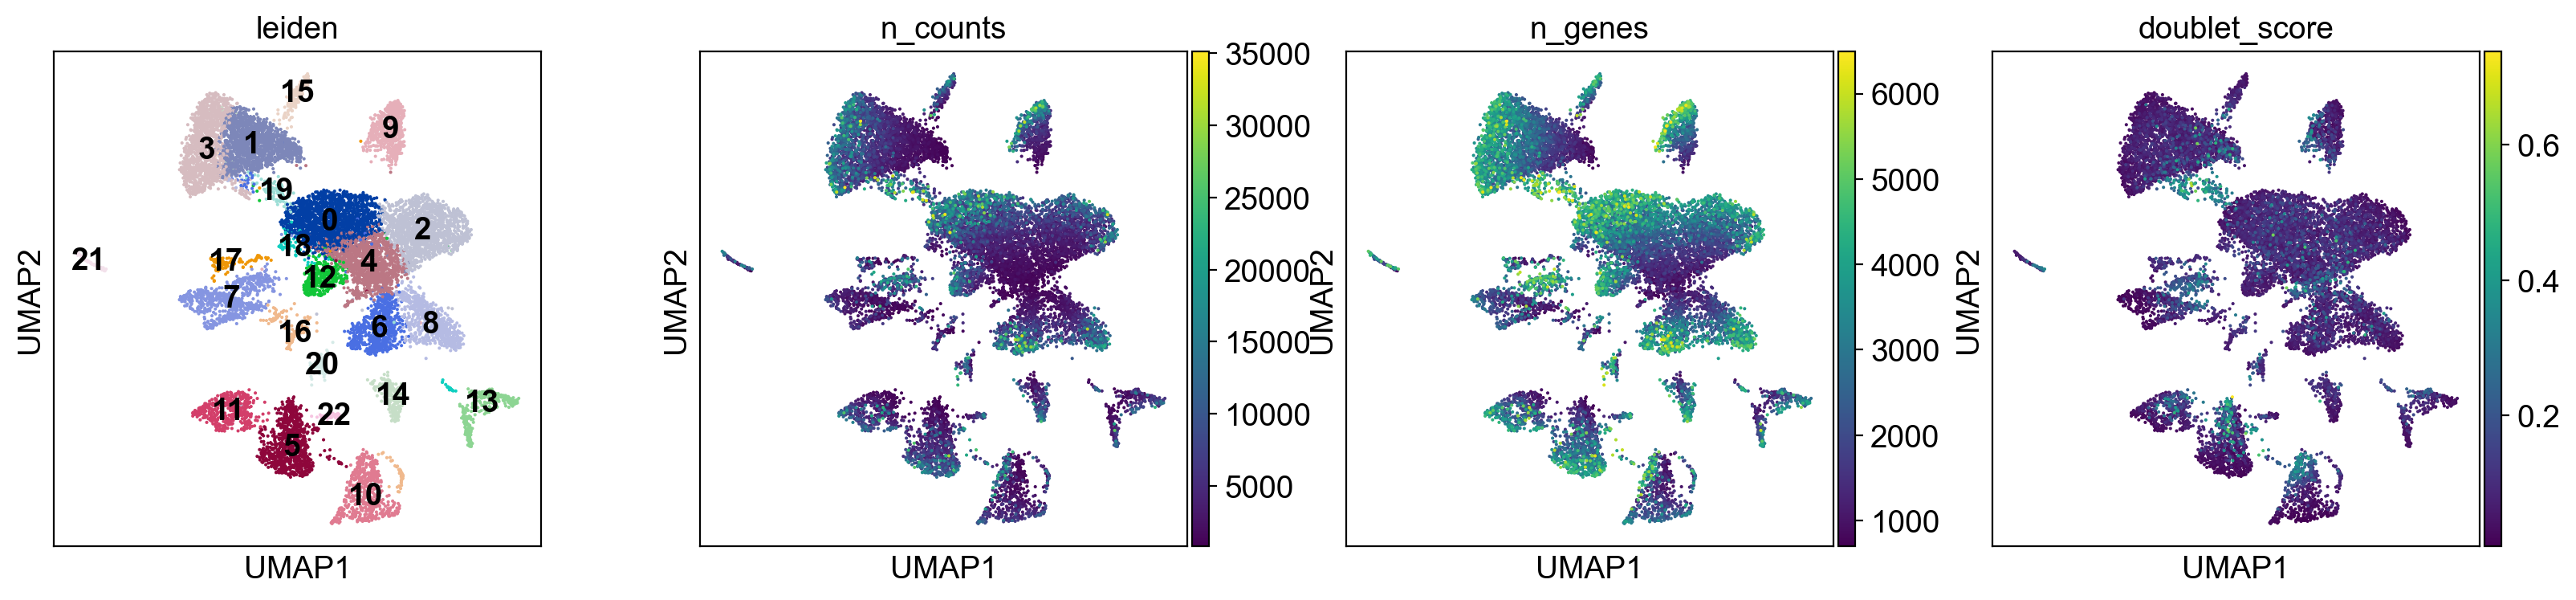

In [123]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=40)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden", "n_counts", "n_genes", "doublet_score"], legend_loc="on data")